# NYC Neighborhood Accessibiliy and Livability Index Clustering

## Intro

Groups New York City neighborhoods (PUMAs) together based on characteristics measuring access and livability.

All data downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

Input Variables:
    
    * Park access: park_access["park_perc"]
    * Job access: job_access["job_perc"]*100/hh_econ["LF_19E"]
    * Access to transit: transit_parks['Percent']
    * Affordable housing: <30% of HH income: 100-housing["GRPI30_19P"],
                          <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership: housing["OOcc1_19P"]
    * Broadband access: housing["Comp_19P"]
    * Computer access: housing["BbInt_19P"]
    * Employment rate: hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Education: Bachelor's degree or higher: hh_econ["Bchpl_19P"]
                 HS graduation rate: 100-hh_econ['HS_19P']
    * Infant mortality: 100-mort_rate["infant_mortality_per1000_16_20"]*10
    * Heat Vulnerability Index: 100-hvi["HVI"]*20

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist, pdist
import scipy.cluster.hierarchy as shc

## Load Data Sets
Downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

In [3]:
path = '../data/'
job_access_path = 'access_to_jobs.csv'
housing_path = 'EDDT_ACS2015-2019.xlsx'
race_dec_path = 'EDDT_Census00-10-20_MUTU.xlsx'
demog_19_path = 'EDDT_Dem_ACS2015-2019.xlsx'
hh_econ_path = 'EDDT_HHEconSec_ACS2015-2019.xlsx'
units_aff_path = 'EDDT_UnitsAffordablebyAMI_2015-2019.xlsx'
dri_path = 'Equitable.Development.Data.Tool.-.Displacement.Risk.Index.2-8-2022.1.xlsx'
park_access_path = 'Park_Access.xlsx'
transit_parks_path = 'EDDE_2023_Updates_transportation.xlsx'
hvi_path = 'HVI_PUMA_Subboro_forSharing.xlsx'
mort_rate_path = 'DOHMH_death rate and overdose.xlsx'

In [4]:
boro_names = ['NYC','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [5]:
park_access = pd.read_excel(f'{path}{park_access_path}')
park_access = park_access.loc[~park_access['PUMA'].isin(boro_names)]
park_access.rename(columns={'Perc':'park_perc','PUMA':'PUMA_short'},inplace=True)
park_access['PUMA'] = '360'+park_access['PUMA_short'].astype(str)
park_access.head()

,PUMA_short,Pop_Served,Total_Pop20,park_perc,PUMA
0,3701,104085,113700,91.543536,3603701
1,3702,94287,148709,63.403694,3603702
2,3703,61828,123837,49.926920,3603703
3,3704,110207,130351,84.546340,3603704
4,3705,176653,178035,99.223748,3603705


In [6]:
hh_econ = pd.read_excel(f'{path}{hh_econ_path}')
hh_econ = hh_econ.loc[~hh_econ['Geog'].isin(boro_names)]
hh_econ['PUMA'] = '360'+hh_econ['Geog'].astype(str)
hh_econ.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z,PUMA
6,3701,77539,1586,1.2,100,NaN,14093,1163,5.0,18.2,...,NaN,NaN,NaN,NaN,139284.0,162682.0,71.0,NaN,NaN,3603701
7,3702,101302,1996,1.2,100,NaN,19953,1337,4.1,19.7,...,NaN,NaN,NaN,NaN,13735.0,37476.0,165.9,NaN,NaN,3603702
8,3703,87544,2326,1.6,100,NaN,14779,1623,6.7,16.9,...,120584.0,473.0,NaN,NaN,22498.0,19396.0,52.4,NaN,NaN,3603703
9,3704,88338,1839,1.3,100,NaN,19059,1212,3.9,21.6,...,5042.0,19.7,NaN,NaN,80657.0,29300.0,22.1,NaN,NaN,3603704
10,3705,101379,2083,1.2,100,NaN,34831,1725,3.0,34.4,...,34808.0,111.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3603705


In [7]:
job_access = pd.read_csv(f'{path}{job_access_path}')
job_access['PUMA'] = job_access['PUMA'].astype(str)
job_access = job_access.loc[~job_access['PUMA'].isin(boro_names)]
job_access = pd.merge(job_access,hh_econ[['PUMA','LF_19E']],how='left',on='PUMA')
# new variable: # of jobs accessible per 100 labor force participants
job_access['job_perc'] = (job_access[
    'Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit']*100)/job_access['LF_19E']
# change values over 100 to 100
job_access['job_perc'] = np.where(job_access['job_perc'] < 100, job_access['job_perc'], 100) 
job_access.head()

,PUMA,Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit,LF_19E,job_perc
0,3603701,45439,50545,89.898111
1,3603702,33763,72051,46.859863
2,3603703,20265,55725,36.366083
3,3603704,53255,60205,88.456108
4,3603705,81569,70950,100.000000


In [8]:
housing = pd.read_excel(f'{path}{housing_path}')
housing = housing.loc[~housing['Geog'].isin(boro_names)]
housing['PUMA'] = '360'+housing['Geog'].astype(str)
housing.head()

,Geog,OcHU1_19E,OcHU1_19M,OcHU1_19C,OcHU1_19P,OcHU1_19Z,OOcc1_19E,OOcc1_19M,OOcc1_19C,OOcc1_19P,...,Comp_A19M,Comp_A19C,Comp_A19P,Comp_A19Z,BbInt_A19E,BbInt_A19M,BbInt_A19C,BbInt_A19P,BbInt_A19Z,PUMA
6,3701,42884,645,0.9,100,NaN,13347,817,3.7,31.1,...,256,10.7,92.9,5.1,1289,236,11.1,82.5,6.0,3603701
7,3702,50543,607,0.7,100,NaN,19234,945,3.0,38.1,...,278,17.9,79.2,16.0,885,240,16.5,74.4,12.2,3603702
8,3703,47805,548,0.7,100,NaN,22513,1265,3.4,47.1,...,278,17.2,75.8,6.9,869,275,19.3,67.1,11.4,3603703
9,3704,44700,549,0.7,100,NaN,13295,810,3.7,29.7,...,340,7.1,90.8,2.3,2389,322,8.2,74.0,5.4,3603704
10,3705,58786,548,0.6,100,NaN,3846,494,7.8,6.5,...,184,34.5,57.4,23.2,310,177,34.6,55.0,22.4,3603705


In [9]:
units_aff = pd.read_excel(f'{path}{units_aff_path}')
units_aff = units_aff.loc[~units_aff['Geog'].isin(boro_names)]
units_aff['PUMA'] = '360'+units_aff['Geog'].astype(str)
units_aff.head()

,Geog,ROcc2_19E,ROcc2_19M,ROcc2_19C,ROcc2_19P,ROcc2_19Z,AfELI_19E,AfELI_19M,AfELI_19C,AfELI_19P,...,AfMidi_19M,AfMidi_19C,AfMidi_19P,AfMidi_19Z,AfHI_19E,AfHI_19M,AfHI_19C,AfHI_19P,AfHI_19Z,PUMA
6,3701,29081,879,1.8,100,NaN,2708,491,11.0,9.3,...,259,15.6,3.5,0.9,159,130.0,49.7,0.5,0.4,3603701
7,3702,30469,1106,2.2,100,NaN,4125,565,8.3,13.5,...,35,77.7,0.1,0.1,12,19.0,98.7,0.0,0.1,3603702
8,3703,24935,1291,3.1,100,NaN,3578,780,13.2,14.3,...,117,47.6,0.6,0.5,33,61.0,111.5,0.1,0.2,3603703
9,3704,30768,959,1.9,100,NaN,3388,447,8.0,11.0,...,118,35.8,0.7,0.4,14,18.0,78.1,0.0,0.1,3603704
10,3705,53565,846,1.0,100,NaN,14696,1130,4.7,27.4,...,61,44.0,0.2,0.1,0,NaN,NaN,NaN,NaN,3603705


In [10]:
race_dec = pd.read_excel(f'{path}{race_dec_path}')
race_dec = race_dec.loc[~race_dec['GeogType'].isin(boro_names)]
race_dec['PUMA'] = ('360'+race_dec['GeoID'].astype(int).astype(str))
race_dec.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P,PUMA
6,PUMA2010,3701.0,113700,100,56187,49.4,34285,30.2,13297,11.7,...,37.4,45378,41.8,14075,13.0,5556,5.1,2960,2.7,3603701
7,PUMA2010,3702.0,148709,100,39442,26.5,8930,6.0,90173,60.6,...,17.5,13783,10.1,90648,66.4,2579,1.9,5474,4.0,3603702
8,PUMA2010,3703.0,123837,100,48297,39.0,31402,25.4,35268,28.5,...,23.4,54501,48.9,26767,24.0,1886,1.7,2306,2.1,3603703
9,PUMA2010,3704.0,130351,100,58209,44.7,26850,20.6,26926,20.7,...,34.7,43076,35.9,23009,19.2,7635,6.4,4640,3.9,3603704
10,PUMA2010,3705.0,178035,100,106163,59.6,7063,4.0,58336,32.8,...,57.3,7689,5.4,48856,34.5,1146,0.8,2848,2.0,3603705


In [14]:
demog_19 = pd.read_excel(f'{path}{demog_19_path}')
demog_19 = demog_19.loc[~demog_19['Geog'].isin(boro_names)]
demog_19['PUMA'] = '360'+demog_19['Geog'].astype(str)
demog_19.head()

,Geog,Pop5p_19E,Pop5p_19M,Pop5p_19C,Pop5p_19P,Pop5p_19Z,LEP_19E,LEP_19M,LEP_19C,LEP_19P,...,P65pl_A19M,P65pl_A19C,P65pl_A19P,P65pl_A19Z,MdAge_A19E,MdAge_A19M,MdAge_A19C,MdAge_A19P,MdAge_A19Z,PUMA
6,3701,102309,2376,1.4,100,NaN,23174,1563,4.1,22.7,...,185,17.1,14.1,3.5,40.2,3.8,5.7,NaN,NaN,3603701
7,3702,140976,2964,1.3,100,NaN,15293,1678,6.7,10.8,...,157,23.0,9.9,2.8,38.8,3.0,4.7,NaN,NaN,3603702
8,3703,113661,3134,1.7,100,NaN,14550,1864,7.8,12.8,...,280,29.6,16.5,7.2,37.5,3.7,6.0,NaN,NaN,3603703
9,3704,118714,2311,1.2,100,NaN,27599,1654,3.6,23.2,...,251,11.1,12.9,1.9,38.6,2.3,3.7,NaN,NaN,3603704
10,3705,156423,2891,1.1,100,NaN,43038,1886,2.7,27.5,...,116,33.7,13.3,6.2,30.0,6.8,13.9,NaN,NaN,3603705


In [15]:
transit_parks = pd.read_excel(f'{path}{transit_parks_path}')
transit_parks['PUMA'] = transit_parks['PUMA'].astype(str)
transit_parks.head()

,PUMA,Pop within 1/4 Mile of Subway Stations and SBS Stops,Total_Pop21,Percent
0,3603701,26984,112474,0.239913
1,3603702,48787,151622,0.321767
2,3603703,15884,119146,0.133315
3,3603704,54384,123579,0.440075
4,3603705,70314,178035,0.394945


In [16]:
mort_rate = pd.read_excel(f'{path}{mort_rate_path}')
mort_rate['PUMA'] = ('360'+mort_rate['PUMA'].astype(str)).str[:7]

mort_rate.head()

,PUMA,infant_mortality_per1000_00_04_W,infant_mortality_per1000_00_04_B,infant_mortality_per1000_00_04_A,infant_mortality_per1000_00_04_H,infant_mortality_per1000_00_04,infant_mortality_per1000_10_14_W,infant_mortality_per1000_10_14_B,infant_mortality_per1000_10_14_A,infant_mortality_per1000_10_14_H,...,overdose_mortality_per100000_00_04,overdose_mortality_per100000_10_14_W,overdose_mortality_per100000_10_14_B,overdose_mortality_per100000_10_14_A,overdose_mortality_per100000_10_14 _H,overdose_mortality_per100000_16_20_W,overdose_mortality_per100000_16_20_B,overdose_mortality_per100000_16_20_A,overdose_mortality_per100000_16_20_H,overdose_mortality_per100000_16_20
0,3603701,*,*,*,6.4,7.5,*,*,*,4.2,...,*,*,*,*,*,21.5,25.8,*,18.3,18.5
1,3603702,0,9.2,*,6.7,8.2,*,7.4,*,7.7,...,*,*,4.5,0,*,58.5,16.5,0,44.2,24.9
2,3603703,*,*,*,*,5.7,*,*,*,*,...,0,22,*,0,*,45.2,12.1,*,25.1,26.8
3,3603704,*,8.9,*,7.4,6.4,*,9.4,*,4.5,...,*,13.9,12.8,*,7.9,33.3,18.3,*,24,22.8
4,3603705,*,11.2,0,5.6,8.1,*,8.4,*,6.9,...,0,77.8,16.4,0,13.5,167.5,60.2,*,38.6,49.2


In [17]:
hvi = pd.read_excel(f'{path}{hvi_path}')
hvi['PUMA'] = '360'+hvi['PUMACE10'].astype(str)
hvi.head()

,PUMACE10,Subboro,HVI,PUMA
0,3701,6,2,3603701
1,3702,10,3,3603702
2,3703,8,1,3603703
3,3704,9,4,3603704
4,3705,2,5,3603705


In [18]:
puma_shape = gpd.read_file(f'{path}NYC_PUMA/geo_export_c1050df7-9a54-46fb-899d-bfbe9cbc5ebf.shp')
puma_shape = puma_shape.to_crs(4326)
puma_shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792563e+07,53229.056289,"POLYGON ((-73.92161 40.87816, -73.92163 40.878..."
1,3702,1.889969e+08,106050.683760,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.672936e+08,304849.899974,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062121e+08,47971.694985,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
4,4015,8.105438e+07,50007.415492,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."


## Data Processing

Input Variables:
    
    * Park access:  park_access["park_perc"]
    * Job access:  job_access["job_perc"]/hh_econ["LF_19E"]
    * Access to transit: transit_parks["Percent"] 
    * Affordable housing:  <30% of HH income: 100-housing["GRPI30_19P"],
                           <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership:  housing["OOcc1_19P"]
    * Broadband access:  housing["Comp_19P"]
    * Computer access:  housing["BbInt_19P"]
    * Employment rate:  hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Education:  Bachelor's degree or higher: hh_econ["Bchpl_19P"]
                  HS graduation rate: hh_econ["HS_19P"]
    * Infant mortality:  100-mort_rate["infant_mortality_per1000_16_20"]*10
    * Heat Vulnerability Index:  100-hvi["HVI"]*20
    

### Create Input Variable Dataframe

In [41]:
data_frames = [park_access[['PUMA','park_perc']], transit_parks[['PUMA','Percent']],
               job_access[['PUMA','job_perc']],
               housing[['PUMA','GRPI30_19P','GRPI50_19P','OOcc1_19P','Comp_19P','BbInt_19P']],
               hh_econ[['PUMA','CvEm1_19E','LF_19E','Bchpl_19P','LtHS_19P']],
               mort_rate[['PUMA','infant_mortality_per1000_16_20']],
               hvi[['PUMA','HVI']]]
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)
df_inputs.head()

,PUMA,park_perc,Percent,job_perc,GRPI30_19P,GRPI50_19P,OOcc1_19P,Comp_19P,BbInt_19P,CvEm1_19E,LF_19E,Bchpl_19P,LtHS_19P,infant_mortality_per1000_16_20,HVI
0,3603701,91.543536,0.239913,89.898111,53.9,29.3,31.1,75.5,73.2,46986.0,50545.0,40.6,18.2,3.38511,2.0
1,3603702,63.403694,0.321767,46.859863,60.7,34.5,38.1,68.2,59.8,65267.0,72051.0,24.4,19.7,6.77924,3.0
2,3603703,49.926920,0.133315,36.366083,49.7,29.4,47.1,73.9,66.2,51509.0,55725.0,26.3,16.9,3.15060,1.0
3,3603704,84.546340,0.440075,88.456108,58.2,30.3,29.7,71.6,60.9,55112.0,60205.0,24.5,21.6,5.05051,4.0
4,3603705,99.223748,0.394945,100.000000,63.9,38.7,6.5,54.6,58.0,62031.0,70950.0,12.8,34.4,6.13354,5.0


In [42]:
df_inputs['Empl_19P'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['Und30_19P'] = 100-df_inputs['GRPI30_19P']
df_inputs['Und50_19P'] = 100-df_inputs['GRPI50_19P']
df_inputs['diploma'] = 100-df_inputs['LtHS_19P']
df_inputs['subway_sbs'] = 100*df_inputs['Percent']
df_inputs['HVI_inverse'] = 100-20*df_inputs['HVI']
df_inputs['inf_mortality_inverse'] = 100-10*df_inputs['infant_mortality_per1000_16_20']
del df_inputs['GRPI30_19P'], df_inputs['GRPI50_19P'], df_inputs['CvEm1_19E'], df_inputs['LF_19E'], df_inputs['Percent'], df_inputs['LtHS_19P'], df_inputs['HVI'], df_inputs['infant_mortality_per1000_16_20']
df_inputs[['park_perc','job_perc','Empl_19P']] = df_inputs[['park_perc','job_perc','Empl_19P']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                          'HS_19P':'diploma','Empl_19P':'empl_rate','Und30_19P':'rent_under30','Und50_19P':'rent_under50'},
                inplace=True)
df_inputs = df_inputs.iloc[:55, :].copy() # remove Na rows
X = df_inputs.iloc[:, 1:] 
df_inputs.head()

,PUMA,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
0,3603701,91.5,89.9,31.1,75.5,73.2,40.6,93.0,46.1,70.7,81.8,23.991322,60.0,66.1489
1,3603702,63.4,46.9,38.1,68.2,59.8,24.4,90.6,39.3,65.5,80.3,32.176729,40.0,32.2076
2,3603703,49.9,36.4,47.1,73.9,66.2,26.3,92.4,50.3,70.6,83.1,13.331543,80.0,68.4940
3,3603704,84.5,88.5,29.7,71.6,60.9,24.5,91.5,41.8,69.7,78.4,44.007477,20.0,49.4949
4,3603705,99.2,100.0,6.5,54.6,58.0,12.8,87.4,36.1,61.3,65.6,39.494481,0.0,38.6646


In [43]:
X.describe()

,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,81.334545,81.583636,32.367273,75.221818,70.012727,36.950909,93.287273,46.647273,71.005455,81.572727,47.697293,40.000000,61.575364
std,15.841042,27.938767,18.707377,9.070316,8.506513,18.595956,2.513155,7.662918,6.240501,8.708520,23.537248,28.544961,15.425395
min,39.000000,8.000000,3.800000,54.600000,54.900000,12.300000,86.600000,31.900000,55.500000,62.200000,0.000000,0.000000,25.286600
25%,70.350000,65.650000,18.150000,70.750000,62.950000,24.950000,92.050000,41.150000,67.300000,75.500000,33.771047,20.000000,49.437850
50%,83.700000,100.000000,30.800000,75.400000,69.700000,32.600000,93.800000,46.300000,70.700000,82.400000,44.007477,40.000000,60.784300
75%,95.600000,100.000000,43.450000,81.550000,76.600000,42.300000,95.200000,51.050000,74.800000,86.900000,66.068673,60.000000,74.284700
max,100.000000,100.000000,81.500000,93.200000,86.100000,83.500000,96.900000,63.500000,83.900000,97.600000,95.307589,80.000000,88.489900


<AxesSubplot:>

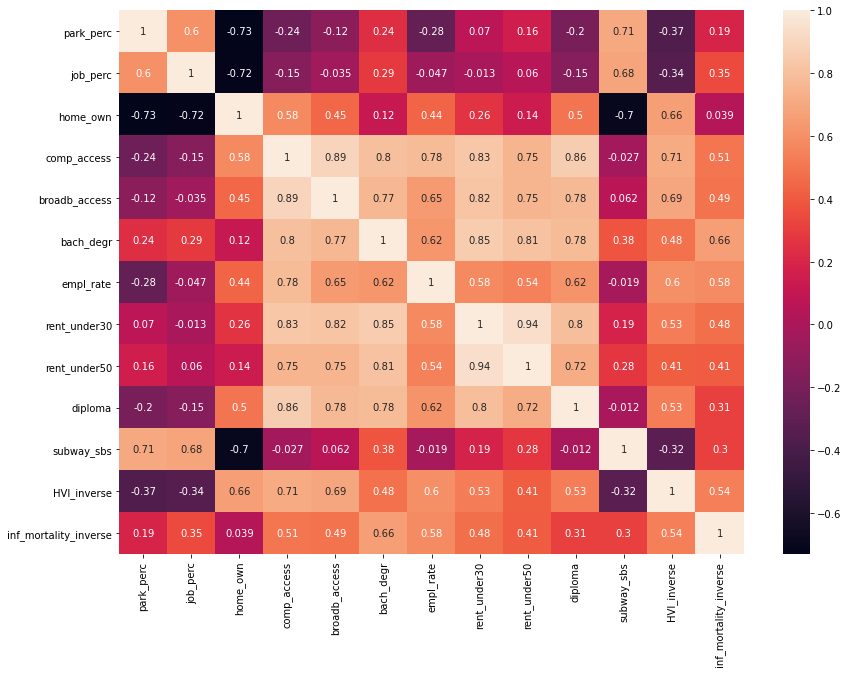

In [44]:
plt.subplots(figsize=(14,10))
sns.heatmap(X.corr(), annot = True)

### Variable Sets
"Full" set (10 variables) - park access, job access, home ownership, computer access, high school diploma, employment rate, rent under 30% of HH income, subway and bus access, heat vulnerability index, infant mortality rate

"Full" set 2 (10 variables) - park access, job access, home ownership, computer access, bachelor's degree, employment rate, rent under 30% of HH income, subway and bus access, heat vulnerability index, infant mortality rate

"Full" set 3 (10 variables) - park access, job access, home ownership, computer access, high school diploma, employment rate, rent under 50% of HH income, subway and bus access, heat vulnerability index, infant mortality rate

"Full" set 4 (10 variables) - park access, job access, home ownership, computer access, bachelor's degree, employment rate, rent under 50% of HH income, subway and bus access, heat vulnerability index, infant mortality rate

"No home ownership" sets (9 variables)

"Condensed" sets?

In [57]:
cols_1F = ['park_perc','job_perc','home_own','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_2F = ['park_perc','job_perc','home_own','comp_access','diploma','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_3F = ['park_perc','job_perc','home_own','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_4F = ['park_perc','job_perc','home_own','comp_access','diploma','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']

df_1F = df_inputs.loc[:, cols_1F]
df_2F = df_inputs.loc[:, cols_2F]
df_3F = df_inputs.loc[:, cols_3F]
df_4F = df_inputs.loc[:, cols_4F]
df_1F.head()

,park_perc,job_perc,home_own,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,HVI_inverse,inf_mortality_inverse
0,91.5,89.9,31.1,75.5,40.6,93.0,46.1,23.991322,60.0,66.1489
1,63.4,46.9,38.1,68.2,24.4,90.6,39.3,32.176729,40.0,32.2076
2,49.9,36.4,47.1,73.9,26.3,92.4,50.3,13.331543,80.0,68.4940
3,84.5,88.5,29.7,71.6,24.5,91.5,41.8,44.007477,20.0,49.4949
4,99.2,100.0,6.5,54.6,12.8,87.4,36.1,39.494481,0.0,38.6646


In [58]:
cols_1NH = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_2NH = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_3NH = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_4NH = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']

df_1NH = df_inputs.loc[:, cols_1NH]
df_2NH = df_inputs.loc[:, cols_2NH]
df_3NH = df_inputs.loc[:, cols_3NH]
df_4NH = df_inputs.loc[:, cols_4NH]
df_1NH.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,HVI_inverse,inf_mortality_inverse
0,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,60.0,66.1489
1,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,40.0,32.2076
2,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,80.0,68.4940
3,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,20.0,49.4949
4,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,0.0,38.6646


In [58]:
cols_1NH = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_2NH = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under30','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_3NH = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']
cols_4NH = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under50','subway_sbs','HVI_inverse','inf_mortality_inverse']

df_1NH = df_inputs.loc[:, cols_1NH]
df_2NH = df_inputs.loc[:, cols_2NH]
df_3NH = df_inputs.loc[:, cols_3NH]
df_4NH = df_inputs.loc[:, cols_4NH]
df_1NH.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,HVI_inverse,inf_mortality_inverse
0,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,60.0,66.1489
1,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,40.0,32.2076
2,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,80.0,68.4940
3,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,20.0,49.4949
4,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,0.0,38.6646


In [77]:
cols_1C = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_2C = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_3C = ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']
cols_4C = ['park_perc','job_perc','comp_access','diploma','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']

df_1C = df_inputs.loc[:, cols_1C]
df_2C = df_inputs.loc[:, cols_2C]
df_3C = df_inputs.loc[:, cols_3C]
df_4C = df_inputs.loc[:, cols_4C]
df_1C.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse
0,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,66.1489
1,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,32.2076
2,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,68.4940
3,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,49.4949
4,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,38.6646


### Standardization

In [65]:
scaler = StandardScaler()

scalerNum = scaler.fit(df_1F)
Fstd = scalerNum.transform(df_1F)
df_1Fstd = pd.DataFrame(Fstd)

In [66]:
scalerNum = scaler.fit(df_2F)
Fstd = scalerNum.transform(df_2F)
df_2Fstd = pd.DataFrame(Fstd)

In [67]:
scalerNum = scaler.fit(df_3F)
Fstd = scalerNum.transform(df_3F)
df_3Fstd = pd.DataFrame(Fstd)

In [68]:
scalerNum = scaler.fit(df_4F)
Fstd = scalerNum.transform(df_4F)
df_4Fstd = pd.DataFrame(Fstd)

In [69]:
scalerNum = scaler.fit(df_1NH)
NHstd = scalerNum.transform(df_1NH)
df_1NHstd = pd.DataFrame(NHstd)

In [70]:
scalerNum = scaler.fit(df_2NH)
NHstd = scalerNum.transform(df_2NH)
df_2NHstd = pd.DataFrame(NHstd)

In [71]:
scalerNum = scaler.fit(df_3NH)
NHstd = scalerNum.transform(df_3NH)
df_3NHstd = pd.DataFrame(NHstd)

In [72]:
scalerNum = scaler.fit(df_4NH)
NHstd = scalerNum.transform(df_4NH)
df_4NHstd = pd.DataFrame(NHstd)

In [79]:
scalerNum = scaler.fit(df_1C)
Cstd = scalerNum.transform(df_1C)
df_1Cstd = pd.DataFrame(Cstd)

In [80]:
scalerNum = scaler.fit(df_2C)
Cstd = scalerNum.transform(df_2C)
df_2Cstd = pd.DataFrame(Cstd)

In [81]:
scalerNum = scaler.fit(df_3C)
Cstd = scalerNum.transform(df_3C)
df_3Cstd = pd.DataFrame(Cstd)

In [82]:
scalerNum = scaler.fit(df_4C)
Cstd = scalerNum.transform(df_4C)
df_4Cstd = pd.DataFrame(Cstd)

### Silhouette and Elbow Methods:

#### Non-Standardized Data

##### K-Means

In [90]:
master_silhouette_list = []

In [91]:
counter = 0
for df in [df_1F, df_2F, df_3F, df_4F]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.3564941622134541
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.32025716801686016
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.3252806100273048
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.3341382253437423
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.3015752932196088
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.28214296498748953
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2545241481035678
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.24277426627454032
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.37580237229246793
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.32835718066801906
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.32254888782234253
For dataset 2 where n_clus

In [92]:
counter = 0
for df in [df_1NH, df_2NH, df_3NH, df_4NH]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.34426808676089693
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.32169333567743424
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.3291570715070395
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.32871699544431066
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.29460670428559543
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.268304050353845
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2720910755969671
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2518906657241175
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.36138303329300103
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.3313793868717246
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.32014989067273003
For dataset 2 where n_clust

In [93]:
counter = 0
for df in [df_1C, df_2C, df_3C, df_4C]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.42423631011888074
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.39022845251825633
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.360784526838221
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.3540554667900915
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.2977809682545187
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.3025558493978952
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.3125662743822467
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.31538881642978284
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.4557108520843486
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.30001838252286517
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.35246441443016474
For dataset 2 where n_cluste

##### Gaussian Mix

In [94]:
counter = 0
for df in [df_1F, df_2F, df_3F, df_4F]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.31336530186957423
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.31230613434983606
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.28057971029351136
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.26634397409938826
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.227160301434712
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.2526193634338273
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2623729625183309
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.23588608512844483
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.3532396670543775
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.32835718066801906
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.27739420760323713
For dataset 2 where n_clus

In [95]:
counter = 0
for df in [df_1NH, df_2NH, df_3NH, df_4NH]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.27325151153978544
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.3195224089005566
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.2960626861652215
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.2708728172715091
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.2569334524705082
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.21498318992073345
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.27209107559696694
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.251031894240584
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.29921219774042046
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.31750129109956987
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.3110115897185001
For dataset 2 where n_cluste

In [96]:
counter = 0
for df in [df_1C, df_2C, df_3C, df_4C]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.3026626036282062
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.33133376090215894
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.35159958720162904
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.32719123296691927
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.31543024488043836
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.317917488188269
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2816029702310901
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.30484616293482686
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.3933475777744673
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.25583654276471746
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.3067530622668321
For dataset 2 where n_clust

#### Standardized Data

##### K-Means

In [97]:
counter = 0
for df in [df_1Fstd, df_2Fstd, df_3Fstd, df_4Fstd]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.25033519985017677
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.30719284723044565
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.2921483397855423
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.30344833260767207
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.34035329810592246
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.31590548900967214
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2836433998742952
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2777123350301617
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.25802437867514155
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.27828293707957863
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.28377530474325074
For dataset 2 where n_cl

In [98]:
counter = 0
for df in [df_1NHstd, df_2NHstd, df_3NHstd, df_4NHstd]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.24699675999607917
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.2975924953857951
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.29727287127625535
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.2981718816625892
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.33182502980712775
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.3134017141980013
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.3085084840834445
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2634647341554964
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.2493649919970833
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.2719843142632857
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.2719666541353434
For dataset 2 where n_cluster

In [99]:
counter = 0
for df in [df_1Cstd, df_2Cstd, df_3Cstd, df_4Cstd]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)        
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.3223871843433441
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.29522817358556563
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.32363545832198254
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.314914061458257
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.32866499557683715
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.31753870069085366
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.31577506799013844
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.28787076065546685
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.2239295197579511
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.2766140776704973
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.3060357263394059
For dataset 2 where n_clust

##### Gaussian Mix

In [100]:
counter = 0
for df in [df_1Fstd, df_2Fstd, df_3Fstd, df_4Fstd]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.1970363919890431
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.29770189551882875
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.27863799393478067
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.29501837266987346
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.33822180050368983
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.29873654911930064
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.28190692251145416
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2777123350301617
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.2527345692028472
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.2649699587263285
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.2787459230031881
For dataset 2 where n_clus

In [101]:
counter = 0
for df in [df_1NHstd, df_2NHstd, df_3NHstd, df_4NHstd]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.19329038859846406
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.2922880664504445
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.2731282355272642
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.29416735873406097
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.31572891128818914
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.30862670570477635
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2835628744482866
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2679241773745617
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.24427257377408182
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.2339958706589808
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.2624840034892587
For dataset 2 where n_clust

In [102]:
counter = 0
for df in [df_1Cstd, df_2Cstd, df_3Cstd, df_4Cstd]:
    counter+=1
    for i in range(2,10):
        rr = GaussianMixture(n_components = i, random_state = 42).fit(df)
        rr.labels_ = rr.predict(df)
        silhouette_avg = silhouette_score(df, rr.labels_, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.3223871843433441
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.251278904470158
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.2988774949234789
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.3145261140997673
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.3015567441938295
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.2949432006473451
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.2640597216233779
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.2665928848789341
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.210163604464852
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.24860433538439453
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.2666629908824218
For dataset 2 where n_clusters = 

In [107]:
max(master_silhouette_list)

0.4593285173625879

In [110]:
sil_list_sorted = sorted(master_silhouette_list,reverse=True)
sil_list_sorted

[0.4593285173625879,
 0.4557108520843486,
 0.4268483885580664,
 0.42423631011888074,
 0.3933475777744673,
 0.39022845251825633,
 0.3776888163753732,
 0.37580237229246793,
 0.3736966139214017,
 0.3634835132223623,
 0.36138303329300103,
 0.360784526838221,
 0.3605387165367682,
 0.3584360671653769,
 0.3579315997071981,
 0.3564941622134541,
 0.3559785752332276,
 0.3550033071104134,
 0.3540554667900915,
 0.3532396670543775,
 0.35246441443016474,
 0.35159958720162904,
 0.34588583894562985,
 0.34586580813920126,
 0.3444525825409559,
 0.34426808676089693,
 0.34307234313014584,
 0.34035329810592246,
 0.33989065827299814,
 0.33822180050368983,
 0.33740698611529957,
 0.335874412957624,
 0.3341382253437423,
 0.33336925482035096,
 0.33336925482035085,
 0.3331443080457402,
 0.3327544166275076,
 0.33218932218262526,
 0.3320834492408619,
 0.33182502980712775,
 0.3316889599293323,
 0.33168895992933217,
 0.3313793868717246,
 0.33133376090215894,
 0.3291570715070395,
 0.3289142646391569,
 0.3287169954443

In [45]:
for i in range(2,11):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(X7)
    silhouette_avg = silhouette_score(X7, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.46008974350441084
For n_clusters = 3 the average silhouette_score is: 0.35676996167111424
For n_clusters = 4 the average silhouette_score is: 0.3176757306576756
For n_clusters = 5 the average silhouette_score is: 0.3072738858191973
For n_clusters = 6 the average silhouette_score is: 0.32580200378232066
For n_clusters = 7 the average silhouette_score is: 0.2984318576745612
For n_clusters = 8 the average silhouette_score is: 0.3277209133965659
For n_clusters = 9 the average silhouette_score is: 0.2950061954440768
For n_clusters = 10 the average silhouette_score is: 0.3150085580375708


In [46]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X7)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

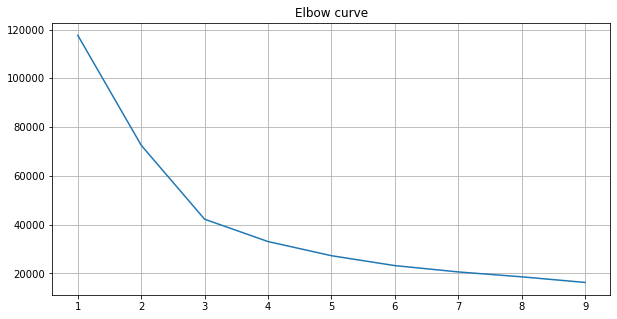

In [47]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

--> Try k=3

## Clustering

K-means approach

Number of clusters, based on Silhoutte and Elbow coefficients:
    
    * Dataset 7 (home ownership included): k=3 (based on elbow method) and k=7 (based on silhouette score)
    * Dataset 6 (home ownership NOT included): k=2 (based on elbow method) and k=5 (based on silhouette score)

#### Dataset 7
where k=7 clusters

In [27]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(X7)
df_inputsT7 = df_inputsT.copy()
df_inputsT7['labels'] = kmeans.labels_
cluster_sumT7 = df_inputsT7.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean','home_own':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumT7.head(7)

,park_perc,job_perc_norm,home_own,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,,
0,91.491667,11.466667,20.216667,73.325000,38.983333,93.283333,47.100000,12
1,60.728571,1.400000,68.014286,81.414286,33.014286,94.485714,48.857143,7
2,95.266667,93.433333,29.333333,90.900000,80.200000,96.100000,60.233333,3
3,95.525000,34.900000,35.250000,88.650000,74.350000,95.600000,60.725000,4
4,70.280000,5.140000,37.260000,75.335000,31.005000,93.700000,44.055000,20
5,96.700000,6.357143,9.842857,59.385714,14.500000,88.342857,36.900000,7
6,100.000000,53.100000,9.200000,68.850000,36.900000,93.450000,47.700000,2


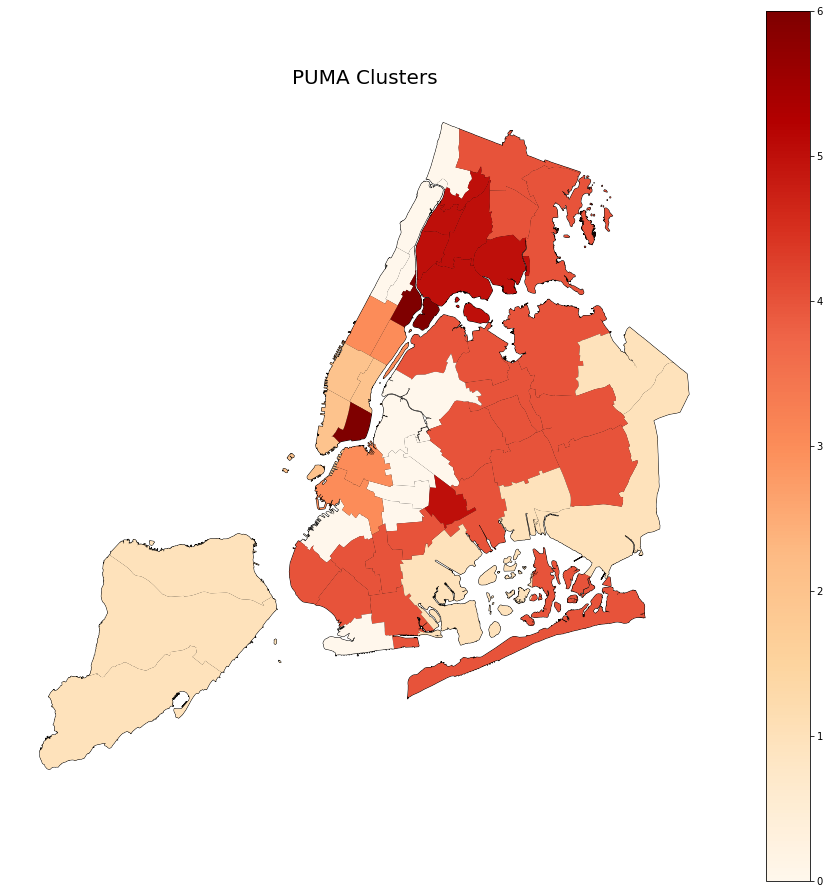

In [28]:
df_inputsT7['puma'] = df_inputsT7['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsT7, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2,3,4,5,6])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 7
where k=3

In [29]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(X7)
df_inputsT3 = df_inputsT.copy()
df_inputsT3['labels'] = kmeans.labels_
cluster_sumT3 = df_inputsT3.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean','home_own':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumT3.head()

,park_perc,job_perc_norm,home_own,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,,
0,65.682609,4.139130,48.091304,77.713043,33.091304,94.078261,45.869565,23
1,95.987500,60.937500,30.050000,87.550000,72.487500,95.650000,58.662500,8
2,91.450000,9.920833,18.070833,68.725000,28.804167,91.741667,43.387500,24


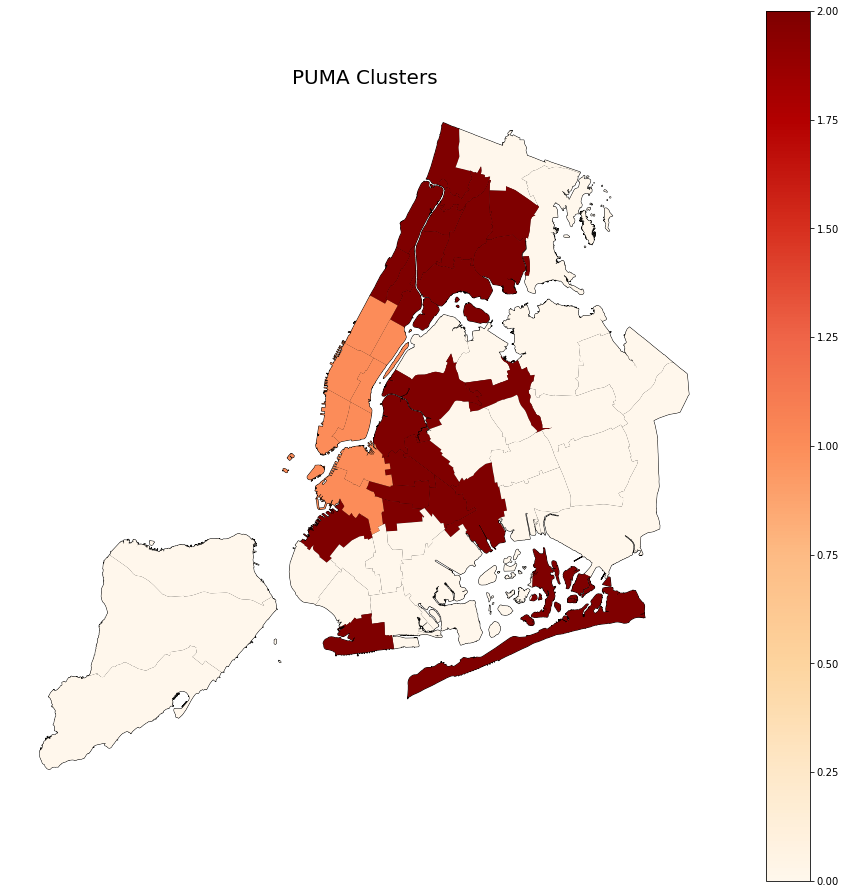

In [30]:
df_inputsT3['puma'] = df_inputsT3['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsT3, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 6
where k=5 clusters

In [31]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(X6)
df_inputsN5 = df_inputsN.copy()
df_inputsN5['labels'] = kmeans.labels_
cluster_sumN5 = df_inputsN5.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumN5.head()

,park_perc,job_perc_norm,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,
0,89.394118,11.482353,73.641176,38.552941,93.105882,47.405882,17
1,65.604348,4.069565,76.921739,30.239130,94.104348,44.873913,23
2,96.450000,86.975000,86.450000,70.625000,95.700000,56.600000,4
3,95.525000,34.900000,88.650000,74.350000,95.600000,60.725000,4
4,96.700000,6.357143,59.385714,14.500000,88.342857,36.900000,7


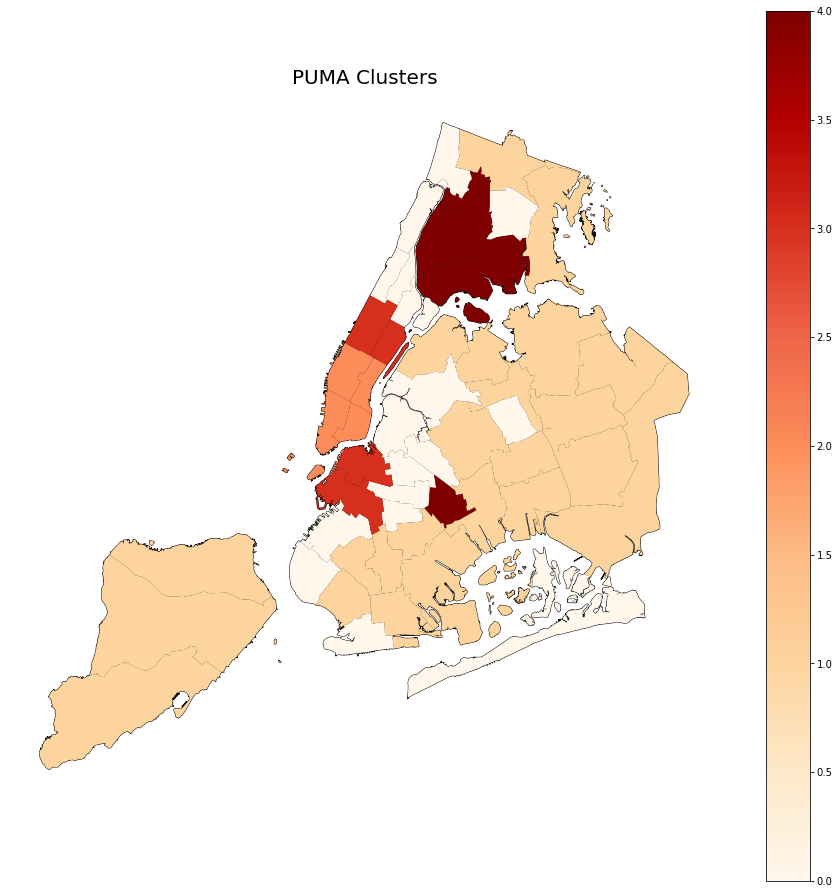

In [32]:
df_inputsN5['puma'] = df_inputsN5['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsN5, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1,2,3,4])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

#### Dataset 6
where k=2

In [33]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(X6)
df_inputsN2 = df_inputsN.copy()
df_inputsN2['labels'] = kmeans.labels_
cluster_sumN2 = df_inputsN2.groupby(['labels']).agg({'park_perc':'mean','job_perc_norm':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'PUMA':'count'})
cluster_sumN2.head()

,park_perc,job_perc_norm,comp_access,bach_degr,empl_rate,rent_under30,PUMA
labels,,,,,,,
0,95.987500,60.937500,87.550000,72.487500,95.650000,58.662500,8
1,78.840426,7.091489,73.123404,30.902128,92.885106,44.602128,47


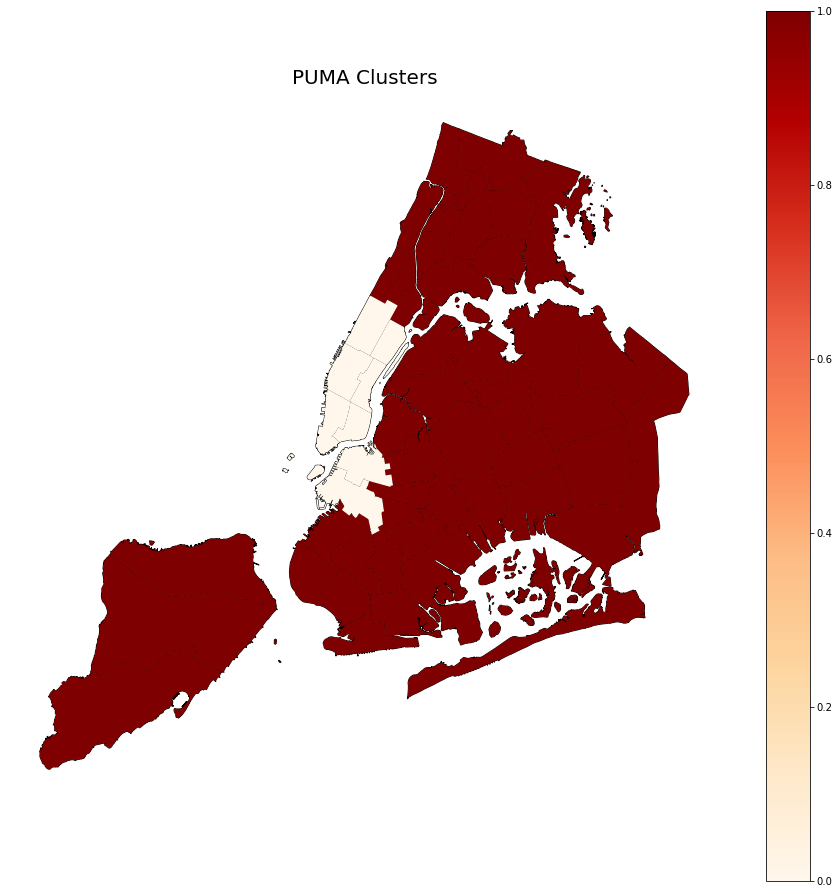

In [34]:
df_inputsN2['puma'] = df_inputsN['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputsN2, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm = plt.cm.ScalarMappable(cmap='OrRd')
sm.set_array([0,1])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

Variables for post-clustering inspection:
    
    * Distribution of household income groups (hh_econ["ELI_19P"], hh_econ["VLI_19P"], hh_econ["LI_19P"], 
    hh_econ["MI_19P"], hh_econ["MIDI_19P"], hh_econ["HI_19P"])
    * Distribution of race/ethnicity groups (race_dec["Hsp20P"], race_dec["WNH20P"], race_dec["BNH20P"],
    race_dec["ANH20P"], race_dec["OTwoNH20P"])